**Chapter 4 – Training Models**

_This notebook contains all the sample code and solutions to the exercises in chapter 4._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/04_training_linear_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/04_training_linear_models.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [2]:
import sys
import sklearn
import matplotlib.pyplot as plt
from packaging import version

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [3]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/training_linear_models` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "training_linear_models"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Linear Regression

## The Normal Equation

To find the value of θ that minimizes the MSE, there exists a closed-form solution. This is called the Normal equation.

Let’s generate some linear-looking data to test this equation

In [5]:
import numpy as np

np.random.seed(42)  # to make this code example reproducible
m = 100  # number of instances
X = 2 * np.random.rand(m, 1)  # column vector
y = 4 + 3 * X + np.random.randn(m, 1)  # column vector

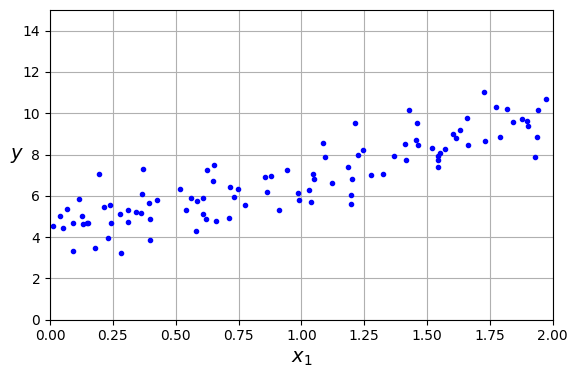

In [6]:
# extra code – generates and saves Figure 4–1

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
save_fig("generated_data_plot")
plt.show()

Now let’s compute θ using the Normal equation. We will use the inv() function from
NumPy’s linear algebra module (np.linalg) to compute the inverse of a matrix, and
the dot() method for matrix multiplication:

In [7]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

In [8]:
theta_best

array([[4.21509616],
       [2.77011339]])

We would have hoped for θ0 = 4 and θ1 = 3 instead of θ0 = 4.215 and θ1 = 2.770.
Close enough, but the noise made it impossible to recover the exact parameters of the
original function. The smaller and noisier the dataset, the harder it gets.

The following code shows the simples example of generating a perfect line and ending up with theta_0 = 4 and theta_1 = 3 as it should be for a perfect line

In [9]:
m2 = 100
X2 = np.arange(m2).reshape(-1, 1)
y2 = 4 + 3 * X2

X_b2 = add_dummy_feature(X2)  # add x0 = 1 to each instance
theta_best2 = np.linalg.inv(X_b2.T @ X_b2) @ X_b2.T @ y2
theta_best2

array([[4.],
       [3.]])

Now we can make predictions using θ_best:

In [10]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)  # add x0 = 1 to each instance
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

In [11]:
X_new

array([[0],
       [2]])

Let’s plot this model’s predictions:

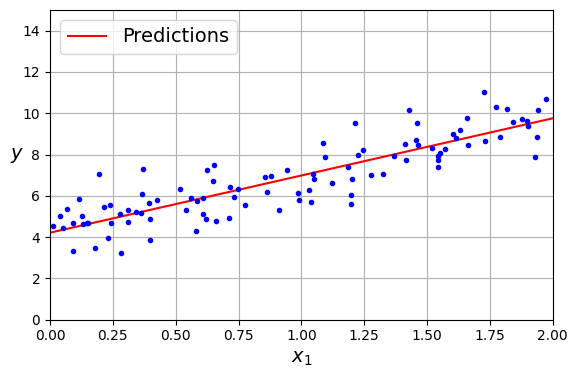

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(X_new, y_predict, "r-", label="Predictions") # the r- argument plots a line between the first and the second point in X, y
plt.plot(X, y, "b.")

# extra code – beautifies and saves Figure 4–2
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")
save_fig("linear_model_predictions_plot")

plt.show()

Performing linear regression using Scikit-Learn is relatively straightforward:

In [13]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [14]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

The `LinearRegression` class is based on the `scipy.linalg.lstsq()` function (the name stands for "least squares"), which you could call directly:

In [15]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

This function computes $\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the _pseudoinverse_ of $\mathbf{X}$ (specifically the Moore-Penrose inverse). You can use `np.linalg.pinv()` to compute the pseudoinverse directly:

In [16]:
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

### **Now we will look at a very different way to train a linear regression model, which is better suited for cases where there are a large number of features or too many training instances to fit in memory.**

# **Gradient Descent**

Gradient descent is a generic optimization algorithm capable of finding optimal solu‐
tions to a wide range of problems. The general idea of gradient descent is to tweak
parameters iteratively in order to minimize a cost function.

An important parameter in gradient descent is the size of the steps, determined by
the learning rate hyperparameter. If the learning rate is too small, then the algorithm
will have to go through many iterations to converge, which will take a long time

On the other hand, if the learning rate is too high, you might jump across the valley
and end up on the other side, possibly even higher up than you were before. This
might make the algorithm diverge, with larger and larger values, failing to find a good
solution

Additionally, not all cost functions look like nice, regular bowls. There may be
holes, ridges, plateaus, and all sorts of irregular terrain, making convergence to the
minimum difficult.

Fortunately, the MSE cost function for a linear regression model happens to be a
convex function, which means that if you pick any two points on the curve, the line
segment joining them is never below the curve. This implies that there are no local
minima, just one global minimum. It is also a continuous function with a slope that
never changes abruptly (**it is Lipschitz continuous**) These two facts have a great consequence: gradient descent
is guaranteed to approach arbitrarily closely the global minimum (if you wait long
enough and if the learning rate is not too high).

While the cost function has the shape of a bowl, it can be an elongated bowl if the
features have very different scales. Figure 4-7 (see the book) shows gradient descent on a training set
where features 1 and 2 have the same scale (on the left), and on a training set where
feature 1 has much smaller values than feature 2 (on the right).3

As you can see, on the left the gradient descent algorithm goes straight toward the
minimum, thereby reaching it quickly, whereas on the right it first goes in a direction
almost orthogonal to the direction of the global minimum, and it ends with a long
march down an almost flat valley. It will eventually reach the minimum, but it will
take a long time.

This diagram also illustrates the fact that training a model means searching for a
combination of model parameters that minimizes a cost function (over the training
set). It is a search in the model’s parameter space. The more parameters a model
has, the more dimensions this space has, and the harder the search is: searching
for a needle in a 300-dimensional haystack is much trickier than in 3 dimensions.
Fortunately, since the cost function is convex in the case of linear regression, the
needle is simply at the bottom of the bowl.

### **Batch Gradient Descent**

To implement gradient descent, you need to compute the gradient of the cost func‐
tion with regard to each model parameter θj. In other words, you need to calculate
how much the cost function will change if you change θj just a little bit. This is called
a partial derivative.

Notice that the formula involves calculations over the full training
set X, at each gradient descent step! This is why the algorithm is
called **batch gradient descent**: it uses the whole batch of training
data at every step (actually, full gradient descent would probably
be a better name). As a result, it is terribly slow on very large
training sets (we will look at some much faster gradient descent
algorithms shortly). However, gradient descent scales well with the
number of features; training a linear regression model when there
are hundreds of thousands of features is much faster using gradient
descent than using the Normal equation or SVD decomposition.

Once you have the gradient vector, which points uphill, just go in the opposite
direction to go downhill. This means subtracting ∇θMSE(θ) from θ. This is where the
learning rate η comes into play: multiply the gradient vector by η to determine the
size of the downhill step

Let’s look at a quick implementation of this algorithm:

In [17]:
eta = 0.1  # learning rate
n_epochs = 1000
m = len(X_b)  # number of instances

np.random.seed(42)
theta = np.random.randn(2, 1)  # randomly initialized model parameters

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

The trained model parameters:

In [18]:
theta

array([[4.21509616],
       [2.77011339]])

Hey, that’s exactly what the Normal equation found! Gradient descent worked per‐
fectly. But what if you had used a different learning rate (eta)?

Next figure shows the first 20 steps of gradient descent using three different learning rates. The line at the bottom of each plot represents the random starting point, then each epoch is represented by a darker and darker line.

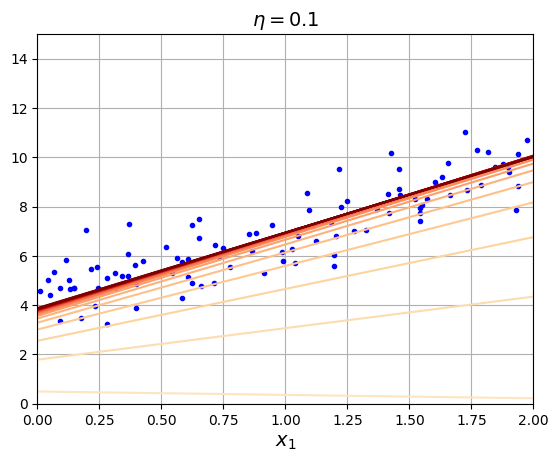

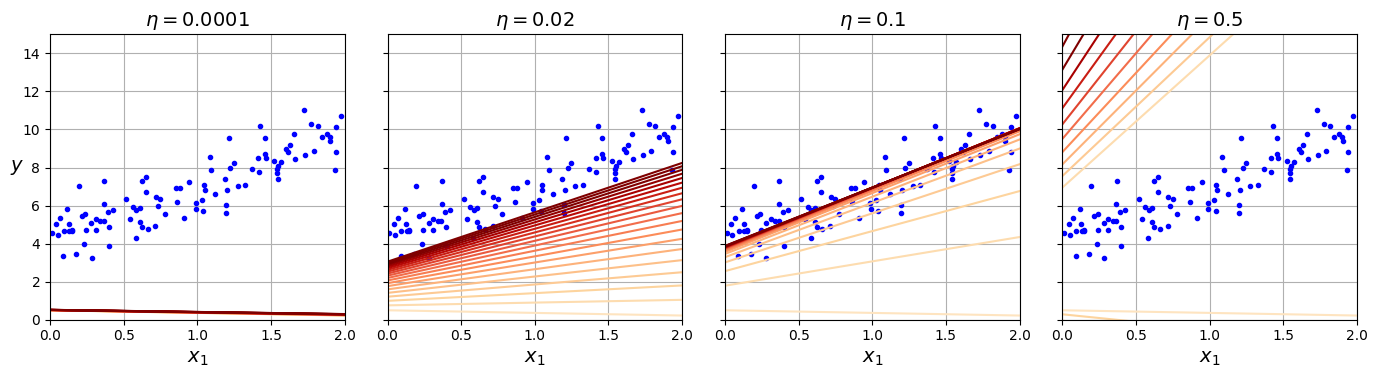

In [19]:
# extra code – generates and saves Figure 4–8

import matplotlib as mpl

def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path


np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)

plt.figure(figsize=(14, 4))

plt.subplot(141)  # subplot 1
plot_gradient_descent(theta, eta=0.0001) # too low, won't converge in 1000 epochs
plt.ylabel("$y$", rotation=0)

plt.subplot(142)  # subplot 2
plot_gradient_descent(theta, eta=0.02) # converge
plt.gca().axes.yaxis.set_ticklabels([])

plt.subplot(143)  # subplot 3
plot_gradient_descent(theta, eta=0.1) # converge faster than the previous one
plt.gca().axes.yaxis.set_ticklabels([])

plt.subplot(144)  # subplot 4
plot_gradient_descent(theta, eta=0.5) # too high: starts below and jump above the line and then go higher and higher
plt.gca().axes.yaxis.set_ticklabels([])

save_fig("gradient_descent_plot")
plt.show()


To find a good learning rate, you can use grid search (see Chapter 2). However, you
may want to limit the number of epochs so that grid search can eliminate models that
take too long to converge.

You may wonder how to set the number of epochs. If it is too low, you will still be
far away from the optimal solution when the algorithm stops; but if it is too high,
you will waste time while the model parameters do not change anymore. A simple
solution is to set a very large number of epochs but to interrupt the algorithm when
the gradient vector becomes tiny—that is, when its norm becomes smaller than a
tiny number ϵ (called the tolerance)—because this happens when gradient descent has
(almost) reached the minimum.

## Stochastic Gradient Descent

The main problem with batch gradient descent is the fact that it uses the whole
training set to compute the gradients at every step, which makes it very slow when
the training set is large. At the opposite extreme, stochastic gradient descent picks a
random instance in the training set at every step and computes the gradients based
only on that single instance. Obviously, working on a single instance at a time makes
the algorithm much faster because it has very little data to manipulate at every
iteration. It also makes it possible to train on huge training sets, since only one
instance needs to be in memory at each iteration

On the other hand, due to its stochastic (i.e., random) nature, this algorithm is
much less regular than batch gradient descent: instead of gently decreasing until it
reaches the minimum, the cost function will bounce up and down, decreasing only
on average. Over time it will end up very close to the minimum, but once it gets there
it will continue to bounce around, never settling down (see Figure 4-9). Once the
algorithm stops, the final parameter values will be good, but not optimal.

When the cost function is very irregular, this can actually help
the algorithm jump out of local minima, so stochastic gradient descent has a better
chance of finding the global minimum than batch gradient descent does.

Therefore, randomness is good to escape from local optima, but bad because it means
that the algorithm can never settle at the minimum. One solution to this dilemma
is to gradually reduce the learning rate. The steps start out large (which helps make
quick progress and escape local minima), then get smaller and smaller, allowing
the algorithm to settle at the global minimum. This process is akin to simulated
annealing, an algorithm inspired by the process in metallurgy of annealing, where
molten metal is slowly cooled down. The function that determines the learning rate at each iteration is called the learning schedule. If the learning rate is reduced too
quickly, you may get stuck in a local minimum, or even end up frozen halfway to
the minimum. If the learning rate is reduced too slowly, you may jump around the
minimum for a long time and end up with a suboptimal solution if you halt training
too early.

The following code implements stochastic gradient descent using a simple learning schedule:

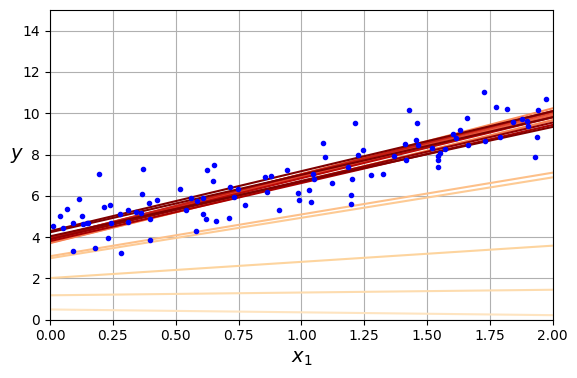

In [20]:
theta_path_sgd = []  # extra code – we need to store the path of theta in the
                     #              parameter space to plot the next figure
                     
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters
m = 100 # number of instances

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

n_shown = 20  # extra code – just needed to generate the figure below
plt.figure(figsize=(6, 4))

for epoch in range(n_epochs):
    for iteration in range(m):

        # extra code – these 4 lines are used to generate the figure
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)

        random_index = np.random.randint(m)            # take a random index from 1 to m
        xi = X_b[random_index : random_index + 1]      # take a random instance from the m possible instances
        yi = y[random_index : random_index + 1]        # the same thing but for y
        gradients = 2 * xi.T @ (xi @ theta - yi)       # calculate the gradient (for SGD, do not divide by m)
        eta = learning_schedule(epoch * m + iteration) # updates eta
        theta = theta - eta * gradients                # updates theta
        theta_path_sgd.append(theta)                   # extra code – to generate the figure
        #print("iteration: ", iteration, "epoch: ", epoch, "index: ", random_index)

# extra code – this section beautifies and saves Figure 4–10
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
save_fig("sgd_plot")
plt.show()

By convention we iterate by rounds of m iterations; each round is called an epoch, as
earlier. While the batch gradient descent code iterated 1,000 times through the whole
training set, this code goes through the training set only 50 times and reaches a pretty
good solution:

In [21]:
theta

array([[4.21076011],
       [2.74856079]])

Note that since instances are picked randomly, some instances may be picked several
times per epoch, while others may not be picked at all. If you want to be sure that the
algorithm goes through every instance at each epoch, another approach is to shuffle
the training set (making sure to shuffle the input features and the labels jointly), then
go through it instance by instance, then shuffle it again, and so on. However, this
approach is more complex, and it generally does not improve the result.

When using stochastic gradient descent, the training instances
must be independent and identically distributed (IID) to ensure
that the parameters get pulled toward the global optimum, on
average. A simple way to ensure this is to shuffle the instances
during training (e.g., pick each instance randomly, or shuffle the
training set at the beginning of each epoch). If you do not shuffle
the instances—for example, if the instances are sorted by label—
then SGD will start by optimizing for one label, then the next, and
so on, and it will not settle close to the global minimum.

To perform linear regression using stochastic GD with Scikit-Learn, you can use
the SGDRegressor class, which defaults to optimizing the MSE cost function. The
following code runs for maximum 1,000 epochs (max_iter) or until the loss drops by
less than 10–5 (tol) during 100 epochs (n_iter_no_change). It starts with a learning
rate of 0.01 (eta0), using the default learning schedule (different from the one we
used). Lastly, it does not use any regularization (penalty=None; more details on this
shortly):

In [22]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)
                       
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets


SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

Once again, you find a solution quite close to the one returned by the Normal
equation:

In [23]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

All Scikit-Learn estimators can be trained using the fit() method,
but some estimators also have a partial_fit() method that you
can call to run a single round of training on one or more instances
(it ignores hyperparameters like max_iter or tol). Repeatedly call‐
ing partial_fit() will gradually train the model. This is useful
when you need more control over the training process. Other
models have a warm_start hyperparameter instead (and some have
both): if you set warm_start=True, calling the fit() method on a
trained model will not reset the model; it will just continue training
where it left off, respecting hyperparameters like max_iter and tol.
Note that fit() resets the iteration counter used by the learning
schedule, while partial_fit() does not.

## Mini-batch gradient descent

The last gradient descent algorithm we will look at is called mini-batch gradient
descent. It is straightforward once you know batch and stochastic gradient descent:
at each step, instead of computing the gradients based on the full training set (as in
batch GD) or based on just one instance (as in stochastic GD), mini-batch GD com‐
putes the gradients on small random sets of instances called mini-batches. The main
advantage of mini-batch GD over stochastic GD is that you can get a performance
boost from hardware optimization of matrix operations, especially when using GPUs.

The algorithm’s progress in parameter space is less erratic than with stochastic GD,
especially with fairly large mini-batches. As a result, mini-batch GD will end up
walking around a bit closer to the minimum than stochastic GD—but it may be
harder for it to escape from local minima (in the case of problems that suffer from
local minima, unlike linear regression with the MSE cost function). Figure generated below
shows the paths taken by the three gradient descent algorithms in parameter space
during training. They all end up near the minimum, but batch GD’s path actually
stops at the minimum, while both stochastic GD and mini-batch GD continue to
walk around. However, don’t forget that batch GD takes a lot of time to take each
step, and stochastic GD and mini-batch GD would also reach the minimum if you
used a good learning schedule.

The code in this section is used to generate the next figure, it is not in the book.

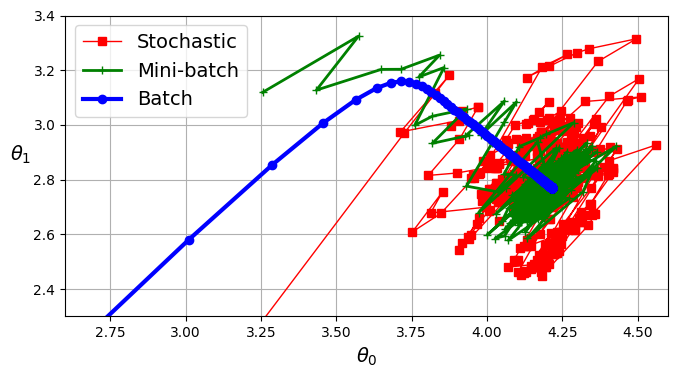

In [24]:
# extra code – this cell generates and saves Figure 4–11

from math import ceil

n_epochs = 50
minibatch_size = 20
n_batches_per_epoch = ceil(m / minibatch_size)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

t0, t1 = 200, 1000  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta_path_mgd = []
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for iteration in range(0, n_batches_per_epoch):
        idx = iteration * minibatch_size
        xi = X_b_shuffled[idx : idx + minibatch_size]
        yi = y_shuffled[idx : idx + minibatch_size]
        gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(iteration)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7, 4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1,
         label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2,
         label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3,
         label="Batch")
plt.legend(loc="upper left")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$   ", rotation=0)
plt.axis([2.6, 4.6, 2.3, 3.4])
plt.grid()
save_fig("gradient_descent_paths_plot")
plt.show()

While the Normal equation can only perform linear regression, the gradient descent algorithms can be used
to train many other models, as you’ll see.

# Polynomial Regression

What if your data is more complex than a straight line? Surprisingly, you can use a
linear model to fit nonlinear data. A simple way to do this is to add powers of each
feature as new features, then train a linear model on this extended set of features. This
technique is called polynomial regression.

Let’s look at an example. First, we’ll generate some nonlinear data (see Figure 4-12),
based on a simple quadratic equation—that’s an equation of the form y = ax² + bx +
c—plus some noise:

In [25]:
np.random.seed(42)
m = 100 # number of instances
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

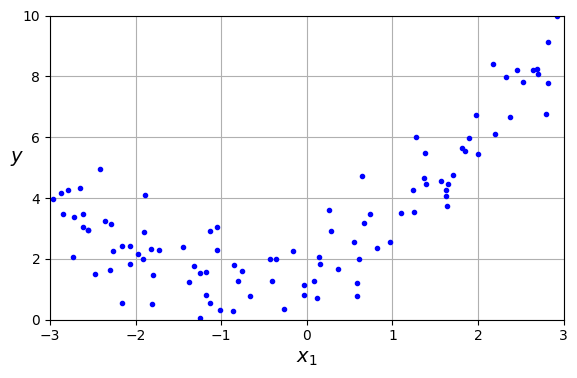

In [26]:
# extra code – this cell generates and saves Figure 4–12
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("quadratic_data_plot")
plt.show()

Clearly, a straight line will never fit this data properly. So let’s use Scikit-Learn’s
PolynomialFeatures class to transform our training data, adding the square (second-
degree polynomial) of each feature in the training set as a new feature (in this case
there is just one feature):

In [27]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [28]:
X[0]

array([-0.75275929])

In [29]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [30]:
X_poly

array([[-7.52759287e-01,  5.66646544e-01],
       [ 2.70428584e+00,  7.31316190e+00],
       [ 1.39196365e+00,  1.93756281e+00],
       [ 5.91950905e-01,  3.50405874e-01],
       [-2.06388816e+00,  4.25963433e+00],
       [-2.06403288e+00,  4.26023172e+00],
       [-2.65149833e+00,  7.03044338e+00],
       [ 2.19705687e+00,  4.82705891e+00],
       [ 6.06690070e-01,  3.68072842e-01],
       [ 1.24843547e+00,  1.55859111e+00],
       [-2.87649303e+00,  8.27421218e+00],
       [ 2.81945911e+00,  7.94934969e+00],
       [ 1.99465584e+00,  3.97865194e+00],
       [-1.72596534e+00,  2.97895634e+00],
       [-1.90905020e+00,  3.64447265e+00],
       [-1.89957294e+00,  3.60837736e+00],
       [-1.17454654e+00,  1.37955958e+00],
       [ 1.48538590e-01,  2.20637127e-02],
       [-4.08329888e-01,  1.66733298e-01],
       [-1.25262516e+00,  1.56906979e+00],
       [ 6.71117368e-01,  4.50398522e-01],
       [-2.16303684e+00,  4.67872835e+00],
       [-1.24713211e+00,  1.55533850e+00],
       [-8.

X_poly now contains the original feature of X and the square of this feature. Now we
can fit a LinearRegression model to this extended training data

In [31]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

LinearRegression()

In [32]:
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

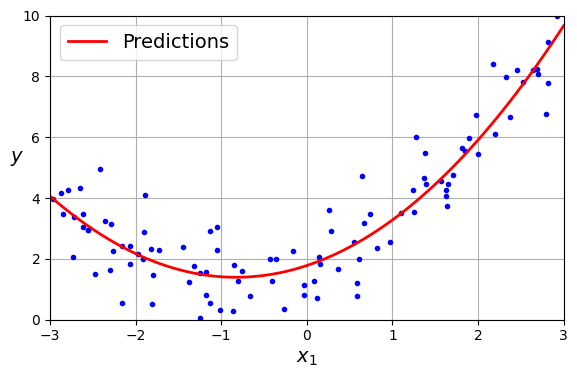

In [33]:
# extra code – this cell generates and saves Figure 4–13

X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("quadratic_predictions_plot")
plt.show()

Degree 3 polynoial just for testing (and fun)

In [34]:
np.random.seed(42)
m_3 = 100
X_3 = 4.5 * np.random.rand(m_3, 1) - 3
y_3 = 0.45 * X_3 ** 3 + 0.12 * X_3 ** 2 + 0.66 * X_3 + 1.2 + np.random.randn(m_3, 1)

In [35]:
poly_features_3 = PolynomialFeatures(degree=3, include_bias=False)
X_poly_3 = poly_features_3.fit_transform(X_3)

In [36]:
X_3[0]

array([-1.31456947])

In [37]:
X_poly_3[0]

array([-1.31456947,  1.72809288, -2.27169813])

In [38]:
lin_reg_3 = LinearRegression()
lin_reg_3.fit(X_poly_3, y_3)
lin_reg_3.intercept_, lin_reg_3.coef_

(array([1.05609398]), array([[0.79426575, 0.14125173, 0.40963342]]))

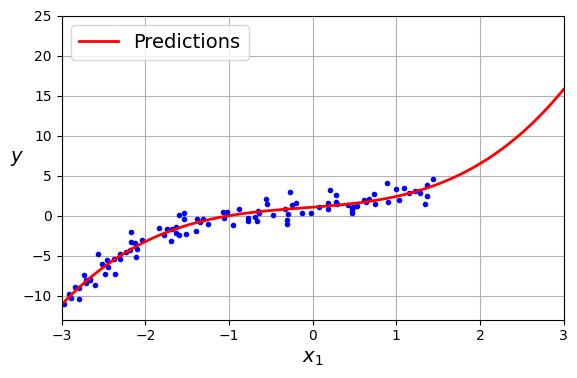

In [39]:
X_new_3 = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly_3 = poly_features_3.transform(X_new_3)
y_new_3 = lin_reg_3.predict(X_new_poly_3)

plt.figure(figsize=(6, 4))
plt.plot(X_3, y_3, "b.")
plt.plot(X_new_3, y_new_3, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper left")
plt.axis([-3, 3, -13, 25])
plt.grid()
save_fig("cubic_predictions_plot")
plt.show()

# Learning Curves

If you perform high-degree polynomial regression, you will likely fit the training data
much better than with plain linear regression. For example, Figure 4-14 applies a
300-degree polynomial model to the preceding training data, and compares the result
with a pure linear model and a quadratic model (second-degree polynomial). Notice
how the 300-degree polynomial model wiggles around to get as close as possible to
the training instances.

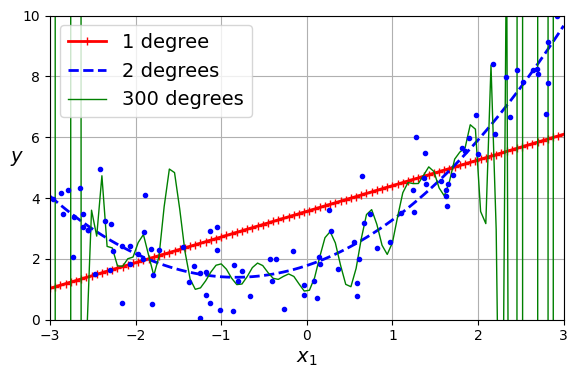

In [40]:
# extra code – this cell generates and saves Figure 4–14

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(6, 4))

for style, width, degree in (("r-+", 2, 1), ("b--", 2, 2), ("g-", 1, 300)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("high_degree_polynomials_plot")
plt.show()

This high-degree polynomial regression model is severely overfitting the training
data, while the linear model is underfitting it. The model that will generalize best in
this case is the quadratic model, which makes sense because the data was generated
using a quadratic model. But in general you won’t know what function generated the
data, so how can you decide how complex your model should be? How can you tell
that your model is overfitting or underfitting the data?

In Chapter 2 you used cross-validation to get an estimate of a model’s generalization
performance. If a model performs well on the training data but generalizes poorly
according to the cross-validation metrics, then your model is overfitting. If it per‐
forms poorly on both, then it is underfitting. This is one way to tell when a model is
too simple or too complex.

Another way to tell is to look at the learning curves, which are plots of the model’s
training error and validation error as a function of the training iteration: just evaluate
the model at regular intervals during training on both the training set and the
validation set, and plot the results. If the model cannot be trained incrementally (i.e.,
if it does not support partial_fit() or warm_start), then you must train it several
times on gradually larger subsets of the training set.

Scikit-Learn has a useful learning_curve() function to help with this: it trains
and evaluates the model using cross-validation. By default it retrains the model on
growing subsets of the training set, but if the model supports incremental learning
you can set exploit_incremental_learning=True when calling learning_curve()
and it will train the model incrementally instead. The function returns the training
set sizes at which it evaluated the model, and the training and validation scores it measured for each size and for each cross-validation fold. Let’s use this function to
look at the learning curves of the plain linear regression model

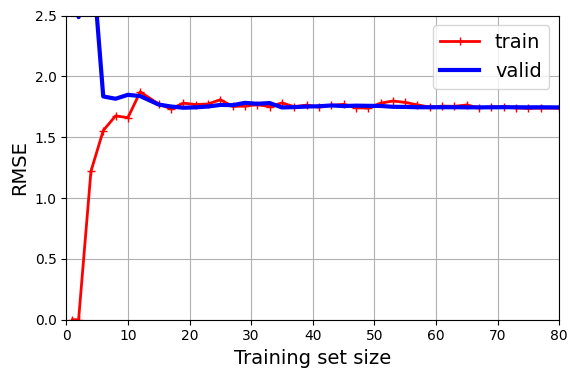

In [41]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
save_fig("underfitting_learning_curves_plot")

plt.show()

This model is underfitting. To see why, first let’s look at the training error. When there
are just one or two instances in the training set, the model can fit them perfectly,
which is why the curve starts at zero. But as new instances are added to the training
set, it becomes impossible for the model to fit the training data perfectly, both because
the data is noisy and because it is not linear at all (it is a second degree polynomial). So the error on the training
data goes up until it reaches a plateau, at which point adding new instances to the
training set doesn’t make the average error much better or worse. Now let’s look at
the validation error. When the model is trained on very few training instances, it is
incapable of generalizing properly, which is why the validation error is initially quite
large. Then, as the model is shown more training examples, it learns, and thus the
validation error slowly goes down. However, once again a straight line cannot do a
good job of modeling the data, so the error ends up at a plateau, very close to the
other curve.

These learning curves are typical of a model that’s underfitting. Both curves have
reached a plateau; they are close and fairly high.

NOTE: If your model is underfitting the training data, adding more train‐
ing examples will not help. You need to use a better model or come
up with better features.

Now let’s look at the learning curves of a 10th-degree polynomial model on the same
data:

In [42]:
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

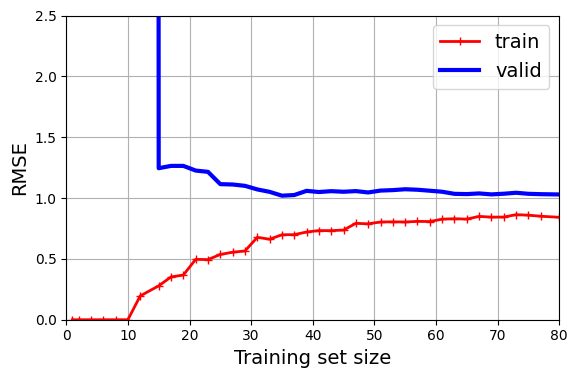

In [43]:
# extra code – generates and saves Figure 4–16

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
save_fig("learning_curves_plot")
plt.show()

These learning curves look a bit like the previous ones, but there are two very
important differences:

• The error on the training data is much lower than before.

• There is a gap between the curves. This means that the model performs signif‐
icantly better on the training data than on the validation data, which is the hallmark of an overfitting model. If you used a much larger training set, however,
the two curves would continue to get closer.

NOTE: One way to improve an overfitting model is to feed it more training
data until the validation error reaches the training error.

## The Bias/Variance Trade-Off

An important theoretical result of statistics and machine learning is the fact that a model’s generalization error can be expressed as the sum of three very different
errors:

**Bias**: This part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data.

**Variance**: This part is due to the model’s excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree
polynomial model) is likely to have high variance and thus overfit the training data.

**Irreducible error**: This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, such as broken sensors, or detect and remove outliers).

Increasing a model’s complexity will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity increases its bias and reduces its variance.

This is why it is called a trade-off.

# Regularized Linear Models

As you saw in Chapters 1 and 2, a good way to reduce overfitting is to regularize the
model (i.e., to constrain it): the fewer degrees of freedom it has, the harder it will be
for it to overfit the data. A simple way to regularize a polynomial model is to reduce
the number of polynomial degrees.

For a linear model, regularization is typically achieved by constraining the weights
of the model. We will now look at ridge regression, lasso regression, and elastic net
regression, which implement three different ways to constrain the weights.

## Ridge Regression

Ridge regression (also called Tikhonov regularization) is a regularized version of linear regression: a regularization term equal to (α/m) ∑i θi is added to the MSE. This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. Note that the regularization term should only be added to the cost function during training. Once the model is trained, you want to use the unregularized MSE (or the RMSE) to evaluate the model’s performance.

The hyperparameter α controls how much you want to regularize the model. If α = 0, then ridge regression is just linear regression. If α is very large, then all weights end up very close to zero and the result is a flat line going through the data’s mean.

J(θ) = MSE(θ) + (α/m) ∑i θi^2

Note that the bias term θ0 is not regularized (the sum starts at i = 1, not 0)

Let's generate a very small and noisy linear dataset:

In [44]:
# extra code – we've done this type of generation several times before
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

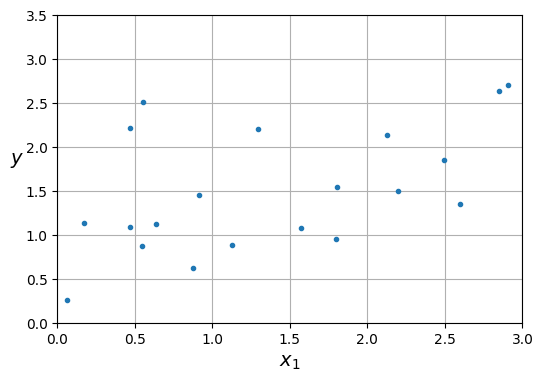

In [45]:
# extra code – a quick peek at the dataset we just generated
plt.figure(figsize=(6, 4))
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

Figure below shows several ridge models that were trained on some very noisy linear data using different α values. On the left, plain ridge models are used, leading to linear predictions. On the right, the data is first expanded using PolynomialFeatures(degree=10), then it is scaled using a StandardScaler, and finally the ridge models are applied to the resulting features: this is polynomial regression with ridge regularization. Note how increasing α leads to flatter (i.e., less extreme, more reasonable) predictions, thus reducing the model’s variance but increasing its bias.

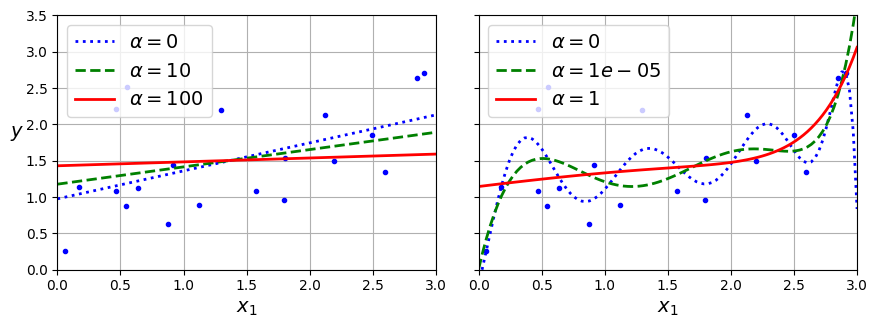

In [46]:
from sklearn.linear_model import Ridge

# extra code – this cell generates and saves Figure 4–17

def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:                                             # if polynomial = True
            model = make_pipeline(                                 # make a pipeline, where:
                PolynomialFeatures(degree=10, include_bias=False), # expand the data in a polynomial of degree 10
                StandardScaler(),                                  # scale it
                model)                                             # and use the model defined as linearRegression or Ridge in the above loop
        model.fit(X, y)                                            # and then fit the model
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2,
                 label=fr"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()

plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
save_fig("ridge_regression_plot")
plt.show()

As with linear regression, we can perform ridge regression either by computing a
closed-form equation or by performing gradient descent. The pros and cons are the
same.

Here is how to perform ridge regression with Scikit-Learn using a closed-form solution that uses a matrix factorization technique by André-Louis Cholesky:

In [47]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55325833]])

And using stochastic gradient descent (Alternatively, you can use the Ridge class with the "sag" solver. Stochastic average GD is a variant of
stochastic GD.):

In [48]:
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1 / m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets
sgd_reg.predict([[1.5]])

array([1.55302613])

The penalty hyperparameter sets the type of regularization term to use. Specifying
"l2" indicates that you want SGD to add a regularization term to the MSE cost
function equal to alpha times the square of the ℓ2 norm of the weight vector. This is
just like ridge regression, except there’s no division by m in this case; that’s why we
passed alpha=0.1 / m, to get the same result as Ridge(alpha=0.1).

The RidgeCV class also performs ridge regression, but it automat‐
ically tunes hyperparameters using cross-validation. It’s roughly
equivalent to using GridSearchCV, but it’s optimized for ridge
regression and runs much faster. Several other estimators (mostly
linear) also have efficient CV variants, such as LassoCV and
ElasticNetCV.

In [49]:
# extra code – show that we get roughly the same solution as earlier when
#              we use Stochastic Average GD (solver="sag")
ridge_reg = Ridge(alpha=0.1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55326019]])

In [50]:
# extra code – shows the closed form solution (see the equation 4.9 in the book, page 157) of Ridge regression,
#              compare with the next Ridge model's learned parameters below
alpha = 0.1
A = np.array([[0., 0.], [0., 1.]])
X_b = np.c_[np.ones(m), X]
np.linalg.inv(X_b.T @ X_b + alpha * A) @ X_b.T @ y

array([[0.97898394],
       [0.3828496 ]])

In [51]:
ridge_reg.intercept_, ridge_reg.coef_  # extra code

(array([0.97896386]), array([[0.38286422]]))

## Lasso Regression

Least absolute shrinkage and selection operator regression (usually simply called lasso
regression) is another regularized version of linear regression: just like ridge regres‐
sion, it adds a regularization term to the cost function, but it uses the ℓ1 norm of
the weight vector instead of the square of the ℓ2 norm:

J(θ) = MSE(θ) + 2α∑i |θi|

Notice that the ℓ1 norm is multiplied by 2α, whereas the ℓ2 norm was multiplied by α / m in ridge regression. These factors were chosen to ensure that the optimal α value is independent from the training set size: different norms lead to different factors.

Figure below shows the same thing as Figure 4-17 but replaces the ridge models with lasso models and uses different α values.

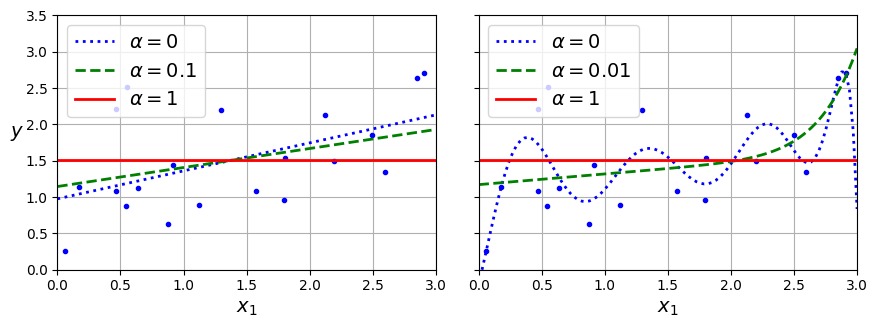

In [52]:
from sklearn.linear_model import Lasso

# extra code – this cell generates and saves Figure 4–18
plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
save_fig("lasso_regression_plot")
plt.show()

An important characteristic of lasso regression is that it tends to eliminate the weights of the least important features (i.e., set them to zero). For example, the dashed line in the righthand plot in Figure above (with α = 0.01) looks roughly cubic: all the weights for the high-degree polynomial features are equal to zero. In other words, lasso regression automatically performs feature selection and outputs a sparse model with few nonzero feature weights.

You can get a sense of why this is the case by looking at Figure below: the axes represent two model parameters, and the background contours represent different loss functions. In the top-left plot, the contours represent the ℓ1 loss (|θ1| + |θ2|), which drops linearly as you get closer to any axis. For example, if you initialize the model parameters to θ1 = 2 and θ2 = 0.5, running gradient descent will decrement both parameters equally (as represented by the dashed yellow line); therefore θ2 will reach 0 first (since it was closer to 0 to begin with). After that, gradient descent will roll down the gutter until it reaches θ1 = 0 (with a bit of bouncing around, since the gradients of ℓ1 never get close to 0: they are either –1 or 1 for each parameter). In the top-right plot, the contours represent lasso regression’s cost function (i.e., an MSE cost function plus an ℓ1 loss). The small white circles show the path that gradient descent takes to optimize some model parameters that were initialized around θ1 = 0.25 and θ2 = –1: notice once again how the path quickly reaches θ2 = 0, then rolls down the gutter and ends up bouncing around the global optimum (represented by the red square). If we increased α, the global optimum would move left along the dashed yellow line, while if we decreased α, the global optimum would move right (in this example, the optimal parameters for the unregularized MSE are θ1 = 2 and θ2 = 0.5).

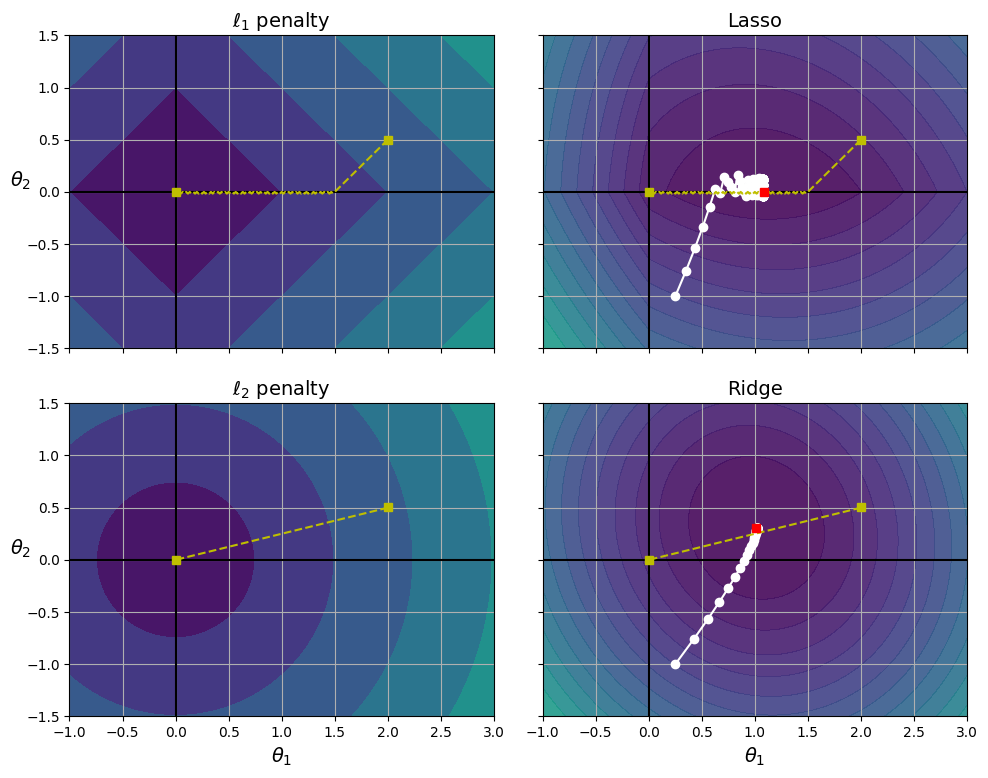

In [53]:
# extra code – this BIG cell generates and saves Figure 4–19

t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1 / len(Xr) * ((T @ Xr.T - yr.T) ** 2).sum(axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(J.argmin(), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

def bgd_path(theta, X, y, l1, l2, core=1, eta=0.05, n_iterations=200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = (core * 2 / len(X) * X.T @ (X @ theta - y)
                     + l1 * np.sign(theta) + l2 * theta)
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))

for i, N, l1, l2, title in ((0, N1, 2.0, 0, "Lasso"), (1, N2, 0, 2.0, "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2 ** 2

    tr_min_idx = np.unravel_index(JR.argmin(), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levels = np.exp(np.linspace(0, 1, 20)) - 1
    levelsJ = levels * (J.max() - J.min()) + J.min()
    levelsJR = levels * (JR.max() - JR.min()) + JR.min()
    levelsN = np.linspace(0, N.max(), 10)

    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(theta=np.array([[2.0], [0.5]]), X=Xr, y=yr,
                      l1=np.sign(l1) / 3, l2=np.sign(l2), core=0)
    ax = axes[i, 0]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, N / 2.0, levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(fr"$\ell_{i + 1}$ penalty")
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")
    ax.set_ylabel(r"$\theta_2$", rotation=0)

    ax = axes[i, 1]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")

save_fig("lasso_vs_ridge_plot")
plt.show()

The two bottom plots show the same thing but with an ℓ2 penalty instead. In the bottom-left plot, you can see that the ℓ2 loss decreases as we get closer to the origin, so gradient descent just takes a straight path toward that point. In the bottom-right plot, the contours represent ridge regression’s cost function (i.e., an MSE cost function plus an ℓ2 loss). As you can see, the gradients get smaller as the parameters approach the global optimum, so gradient descent naturally slows down. This limits the bouncing around, which helps ridge converge faster than lasso regression. Also note that the optimal parameters (represented by the red square) get closer and closer to the origin when you increase α, but they never get eliminated entirely.

To keep gradient descent from bouncing around the optimum at
the end when using lasso regression, you need to gradually reduce
the learning rate during training. It will still bounce around the
optimum, but the steps will get smaller and smaller, so it will
converge.

The lasso cost function is not differentiable at θi = 0 (for i = 1, 2, ⋯, n), but gradient descent still works if you use a subgradient vector g^11 instead when any θi = 0.

Here is a small Scikit-Learn example using the Lasso class:

In [54]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

## Elastic Net

Elastic net regression is a middle ground between ridge regression and lasso regression. The regularization term is a weighted sum of both ridge and lasso’s regularization terms, and you can control the mix ratio r. When r = 0, elastic net is equivalent to ridge regression, and when r = 1, it is equivalent to lasso regression:

J(θ) = MSE(θ) + r(2α∑i |θi|) + (1 − r)(α/m ∑i θi^2)

So when should you use elastic net regression, or ridge, lasso, or plain linear regression (i.e., without any regularization)? It is almost always preferable to have at least a little bit of regularization, so generally you should avoid plain linear regression. Ridge is a good default, but if you suspect that only a few features are useful, you should prefer lasso or elastic net because they tend to reduce the useless features’ weights down to zero, as discussed earlier. In general, elastic net is preferred over lasso because lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.

Here is a short example that uses Scikit-Learn’s ElasticNet (l1_ratio corresponds to the mix ratio r):

In [55]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

## Early Stopping

A very different way to regularize iterative learning algorithms such as gradient
descent is to stop training as soon as the validation error reaches a minimum. This is
called early stopping.

Figure below shows a complex model (in this case, a high-degree polynomial regression model) being trained with batch gradient descent on the quadratic dataset we used earlier. As the epochs go by, the algorithm learns, and its prediction error (RMSE) on the training set goes down, along with its prediction error on the validation set. After a while, though, the validation error stops decreasing and starts to go back up. This indicates that the model has started to overfit the training data.
With early stopping you just stop training as soon as the validation error reaches the minimum.

/home/silviojr/.virtualenvs/handson/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/silviojr/.virtualenvs/handson/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/silviojr/.virtualenvs/handson/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/silviojr/.virtualenvs/handson/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in ve

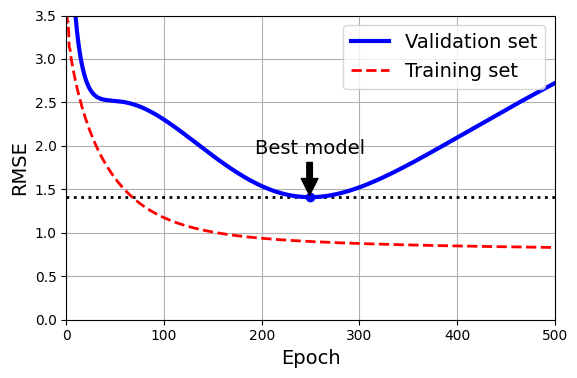

In [56]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# extra code – creates the same quadratic dataset as earlier and splits it
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')
train_errors, val_errors = [], []  # extra code – it's for the figure below

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    # extra code – we evaluate the train error and save it for the figure
    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = mean_squared_error(y_train, y_train_predict, squared=False)
    val_errors.append(val_error)
    train_errors.append(train_error)

# extra code – this section generates and saves Figure 4–20
best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()
save_fig("early_stopping_plot")
plt.show()

Note: With stochastic and mini-batch gradient descent, the curves are
not so smooth, and it may be hard to know whether you have
reached the minimum or not. One solution is to stop only after the
validation error has been above the minimum for some time (when
you are confident that the model will not do any better), then roll
back the model parameters to the point where the validation error
was at a minimum.

This code first adds the polynomial features and scales all the input features, both
for the training set and for the validation set (the code assumes that you have split
the original training set into a smaller training set and a validation set). Then it
creates an SGDRegressor model with no regularization and a small learning rate. In
the training loop, it calls partial_fit() instead of fit(), to perform incremental
learning. At each epoch, it measures the RMSE on the validation set. If it is lower
than the lowest RMSE seen so far, it saves a copy of the model in the best_model
variable. This implementation does not actually stop training, but it lets you revert to
the best model after training. Note that the model is copied using copy.deepcopy(),
because it copies both the model’s hyperparameters and the learned parameters. In
contrast, sklearn.base.clone() only copies the model’s hyperparameters.

# Logistic Regression

As discussed in Chapter 1, some regression algorithms can be used for classification
(and vice versa). Logistic regression (also called logit regression) is commonly used to
estimate the probability that an instance belongs to a particular class (e.g., what is
the probability that this email is spam?). If the estimated probability is greater than a
given threshold (typically 50%), then the model predicts that the instance belongs to
that class (called the positive class, labeled “1”), and otherwise it predicts that it does
not (i.e., it belongs to the negative class, labeled “0”). This makes it a binary classifier.

## Estimating Probabilities

So how does logistic regression work? Just like a linear regression model, a logistic regression model computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like the linear regression model does, it outputs the logistic of this result:

p = ℎ_θ(x) = σ(θ^T x)

The logistic — noted σ(·) — is a sigmoid function that outputs a number between 0 and 1:

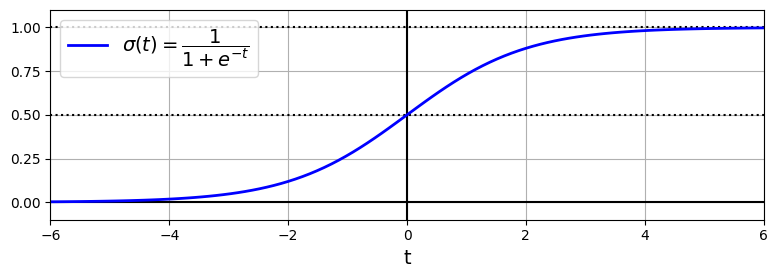

In [57]:
# extra code – generates and saves Figure 4–21

lim = 6
t = np.linspace(-lim, lim, 100)
sig = 1 / (1 + np.exp(-t))

plt.figure(figsize=(8, 3))
plt.plot([-lim, lim], [0, 0], "k-")
plt.plot([-lim, lim], [0.5, 0.5], "k:")
plt.plot([-lim, lim], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \dfrac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left")
plt.axis([-lim, lim, -0.1, 1.1])
plt.gca().set_yticks([0, 0.25, 0.5, 0.75, 1])
plt.grid()
save_fig("logistic_function_plot")
plt.show()

Once the logistic regression model has estimated the probability p = h_θ(x) that an instance x belongs to the positive class, it can make its prediction ŷ easily (using a 50% threshold for example):

    
y = 0 if p < 0.5 or 1 if p ≥ 0.5

Notice that σ(t) < 0.5 when t < 0, and σ(t) ≥ 0.5 when t ≥ 0, so a logistic regression
model using the default threshold of 50% probability predicts 1 if θ⊺ x is positive and
0 if it is negative.

## Training and cost function

Now you know how a logistic regression model estimates probabilities and makes
predictions. But how is it trained? The objective of training is to set the parameter
vector θ so that the model estimates high probabilities for positive instances (y = 1)
and low probabilities for negative instances (y = 0). This idea is captured by the cost
function shown in Equation below for **a single training instance x**:

cθ = −log(p) if y = 1, −log(1 − p) if y = 0

This cost function makes sense because –log(t) grows very large when t approaches 0,
so the cost will be large if the model estimates a probability close to 0 for a positive
instance, and it will also be large if the model estimates a probability close to 1 for a
negative instance. On the other hand, –log(t) is close to 0 when t is close to 1, so the
cost will be close to 0 if the estimated probability is close to 0 for a negative instance
or close to 1 for a positive instance, which is precisely what we want.

The cost function over the whole training set is the average cost over all training
instances. It can be written in a single expression called the log loss, shown in
Equation 4-17 (see the book, page 166).

The bad news is that there is no known closed-form equation to compute the value of
θ that minimizes this cost function (there is no equivalent of the Normal equation).
But the good news is that this cost function is convex, so gradient descent (or any
other optimization algorithm) is guaranteed to find the global minimum (if the
learning rate is not too large and you wait long enough).

## Note - VERY IMPORTANT

The log loss was not just pulled out of a hat. It can be shown
mathematically (using Bayesian inference) that minimizing this
loss will result in the model with the maximum likelihood of being
optimal, assuming that the instances follow a Gaussian distribution
around the mean of their class. When you use the log loss, this
is the implicit assumption you are making. The more wrong this
assumption is, the more biased the model will be. Similarly, when
we used the MSE to train linear regression models, we were implic‐
itly assuming that the data was purely linear, plus some Gaussian
noise. So, if the data is not linear (e.g., if it’s quadratic) or if the
noise is not Gaussian (e.g., if outliers are not exponentially rare),
then the model will be biased.

## Decision Boundaries

We can use the iris dataset to illustrate logistic regression. This is a famous dataset
that contains the sepal and petal length and width of 150 iris flowers of three different
species: Iris setosa, Iris versicolor, and Iris virginica

Let’s try to build a classifier to detect the Iris virginica type based only on the petal
width feature. The first step is to load the data and take a quick peek:

In [58]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [59]:
print(iris.DESCR)  # extra code – it's a bit too long

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [60]:
iris.data.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [61]:
iris.target.head(3)  # note that the instances are not shuffled

0    0
1    0
2    0
Name: target, dtype: int64

In [62]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Next we’ll split the data and train a logistic regression model on the training set:

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [64]:
X

array([[0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.4],
       [0.3],
       [0.2],
       [0.2],
       [0.1],
       [0.2],
       [0.2],
       [0.1],
       [0.1],
       [0.2],
       [0.4],
       [0.4],
       [0.3],
       [0.3],
       [0.3],
       [0.2],
       [0.4],
       [0.2],
       [0.5],
       [0.2],
       [0.2],
       [0.4],
       [0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.4],
       [0.1],
       [0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.1],
       [0.2],
       [0.2],
       [0.3],
       [0.3],
       [0.2],
       [0.6],
       [0.4],
       [0.3],
       [0.2],
       [0.2],
       [0.2],
       [0.2],
       [1.4],
       [1.5],
       [1.5],
       [1.3],
       [1.5],
       [1.3],
       [1.6],
       [1. ],
       [1.3],
       [1.4],
       [1. ],
       [1.5],
       [1. ],
       [1.4],
       [1.3],
       [1.4],
       [1.5],
       [1. ],
       [1.5],
       [1.1],
       [1.8],
      

In [65]:
y

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [66]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

Let’s look at the model’s estimated probabilities for flowers with petal widths varying
from 0 cm to 3 cm

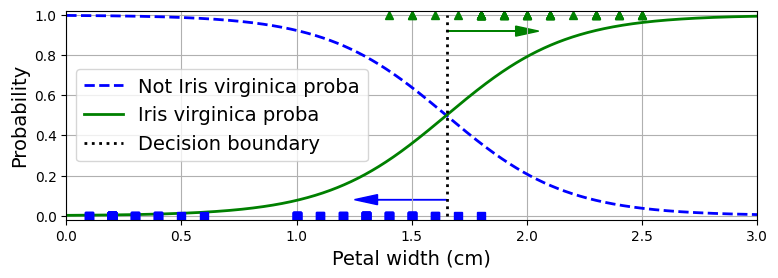

In [67]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)  # reshape to get a column vector
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]

plt.figure(figsize=(8, 3))  # extra code – not needed, just formatting
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2,
         label="Not Iris virginica proba")
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica proba")
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2,
         label="Decision boundary")

# extra code – this section beautifies and saves Figure 4–23
plt.arrow(x=decision_boundary, y=0.08, dx=-0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(x=decision_boundary, y=0.92, dx=0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="g", ec="g")
plt.plot(X_train[y_train == 0], y_train[y_train == 0], "bs")
plt.plot(X_train[y_train == 1], y_train[y_train == 1], "g^")
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend(loc="center left")
plt.axis([0, 3, -0.02, 1.02])
plt.grid()
save_fig("logistic_regression_plot")

plt.show()

In [68]:
decision_boundary

1.6516516516516517

The petal width of Iris virginica flowers (represented as triangles) ranges from 1.4
cm to 2.5 cm, while the other iris flowers (represented by squares) generally have
a smaller petal width, ranging from 0.1 cm to 1.8 cm. Notice that there is a bit of
overlap. Above about 2 cm the classifier is highly confident that the flower is an Iris
virginica (it outputs a high probability for that class), while below 1 cm it is highly confident that it is not an Iris virginica (high probability for the “Not Iris virginica” class). In between these extremes, the classifier is unsure. However, if you ask it
to predict the class (using the predict() method rather than the predict_proba()
method), it will return whichever class is the most likely. Therefore, there is a decision
boundary at around 1.6 cm where both probabilities are equal to 50%: if the petal
width is greater than 1.6 cm the classifier will predict that the flower is an Iris
virginica, and otherwise it will predict that it is not (even if it is not very confident):

In [69]:
log_reg.predict([[1.7], [1.5]])

array([ True, False])

Figure below shows the same dataset, but this time displaying two features: petal width
and length. Once trained, the logistic regression classifier can, based on these two
features, estimate the probability that a new flower is an Iris virginica. The dashed line
represents the points where the model estimates a 50% probability: this is the model’s
decision boundary. Note that it is a linear boundary. Each parallel line represents the
points where the model outputs a specific probability, from 15% (bottom left) to 90%
(top right). All the flowers beyond the top-right line have over 90% chance of being
Iris virginica, according to the model.

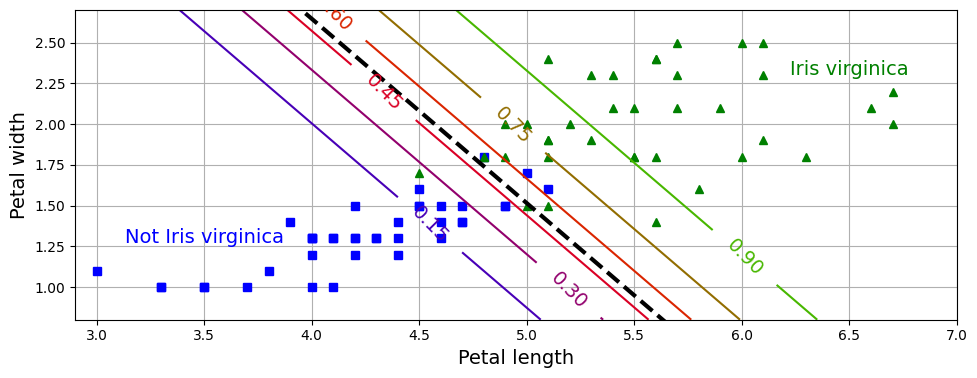

In [70]:
# extra code – this cell generates and saves Figure 4–24

X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(C=2, random_state=42)
log_reg.fit(X_train, y_train)

# for the contour plot
x0, x1 = np.meshgrid(np.linspace(2.9, 7, 500).reshape(-1, 1),
                     np.linspace(0.8, 2.7, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]  # one instance per point on the figure
y_proba = log_reg.predict_proba(X_new)
zz = y_proba[:, 1].reshape(x0.shape)

# for the decision boundary
left_right = np.array([2.9, 7])
boundary = -((log_reg.coef_[0, 0] * left_right + log_reg.intercept_[0])
             / log_reg.coef_[0, 1])

plt.figure(figsize=(10, 4))
plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], "bs")
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], "g^")
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
plt.clabel(contour, inline=1)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.27, "Not Iris virginica", color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", color="g", ha="center")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([2.9, 7, 0.8, 2.7])
plt.grid()
save_fig("logistic_regression_contour_plot")
plt.show()

## Softmax Regression

The logistic regression model can be generalized to support multiple classes directly,
without having to train and combine multiple binary classifiers (as discussed in
Chapter 3). This is called softmax regression, or multinomial logistic regression.

The idea is simple: when given an instance x, the softmax regression model first
computes a score sk(x) for each class k, then estimates the probability of each class by
applying the softmax function (also called the normalized exponential) to the scores.
The equation to compute sk(x) should look familiar, as it is just like the equation for
linear regression prediction:

s_k(x) = (θ^(k))^T x - (Softmax score for class k)

Note that each class k has its own dedicated parameter vector θ^(k). All these vectors are
typically stored as rows in a parameter matrix Θ.

Once you have computed the score of every class for the instance x, you can estimate
the probability p_k that the instance belongs to class k by running the scores through
the softmax function. The function computes the exponential of
every score, then normalizes them (dividing by the sum of all the exponentials). The
scores are generally called logits or log-odds (although they are actually unnormal‐
ized log-odds).

p_k = σ(s(x))_k = exp(s_k(x)) / ∑_j^k exp(s_j(x)) - (Softmax function)

In this equation:

• K is the number of classes.

• s(x) is a vector containing the scores of each class for the instance x.

• σ(s(x))_k is the estimated probability that the instance x belongs to class k, given
the scores of each class for that instance.

Just like the logistic regression classifier, by default the softmax regression classifier
predicts the class with the highest estimated probability (which is simply the class
with the highest score):

y = argmax_k σ(s(x))_k = argmax_k s_k(x) = argmax_k ((θ^(k))^T x) - (Softmax regression classifier prediction)

NOTE: The softmax regression classifier predicts only one class at a time
(i.e., it is multiclass, not multioutput), so it should be used only
with mutually exclusive classes, such as different species of plants.
You cannot use it to recognize multiple people in one picture.

Let’s use softmax regression to classify the iris plants into all three classes. Scikit-
Learn’s LogisticRegression classifier uses softmax regression automatically when
you train it on more than two classes (assuming you use solver="lbfgs", which is
the default). It also applies ℓ2 regularization by default, which you can control using
the hyperparameter C, as mentioned earlier:

In [73]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X

array([[1.4, 0.2],
       [1.4, 0.2],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.7, 0.4],
       [1.4, 0.3],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.5, 0.1],
       [1.5, 0.2],
       [1.6, 0.2],
       [1.4, 0.1],
       [1.1, 0.1],
       [1.2, 0.2],
       [1.5, 0.4],
       [1.3, 0.4],
       [1.4, 0.3],
       [1.7, 0.3],
       [1.5, 0.3],
       [1.7, 0.2],
       [1.5, 0.4],
       [1. , 0.2],
       [1.7, 0.5],
       [1.9, 0.2],
       [1.6, 0.2],
       [1.6, 0.4],
       [1.5, 0.2],
       [1.4, 0.2],
       [1.6, 0.2],
       [1.6, 0.2],
       [1.5, 0.4],
       [1.5, 0.1],
       [1.4, 0.2],
       [1.5, 0.2],
       [1.2, 0.2],
       [1.3, 0.2],
       [1.4, 0.1],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.3, 0.3],
       [1.3, 0.3],
       [1.3, 0.2],
       [1.6, 0.6],
       [1.9, 0.4],
       [1.4, 0.3],
       [1.6, 0.2],
       [1.4, 0.2],
       [1.5, 0.2],
       [1.4, 0.2],
       [4.7, 1.4],
       [4.5, 1.5],
       [4.9,

In [74]:
softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)

LogisticRegression(C=30, random_state=42)

So the next time you find an iris with petals that are 5 cm long and 2 cm wide, you
can ask your model to tell you what type of iris it is, and it will answer Iris virginica
(class 2) with 96% probability (or Iris versicolor with 4% probability):

In [75]:
softmax_reg.predict([[5, 2]])

array([2])

In [76]:
softmax_reg.predict_proba([[5, 2]]).round(2)

array([[0.  , 0.04, 0.96]])

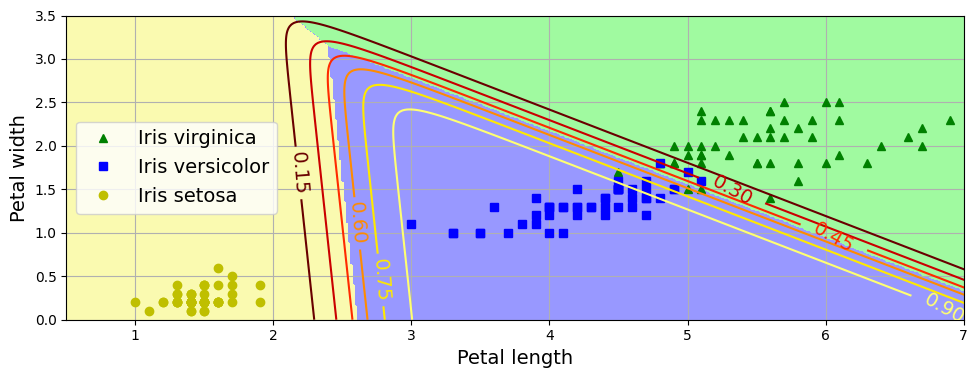

In [77]:
# extra code – this cell generates and saves Figure 4–25

from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="center left")
plt.axis([0.5, 7, 0, 3.5])
plt.grid()
save_fig("softmax_regression_contour_plot")
plt.show()

Figure above shows the resulting decision boundaries, represented by the background
colors. Notice that the decision boundaries between any two classes are linear. The
figure also shows the probabilities for the Iris versicolor class, represented by the curved lines (e.g., the line labeled with 0.30 represents the 30% probability bound‐
ary). Notice that the model can predict a class that has an estimated probability below
50%. For example, at the point where all decision boundaries meet, all classes have an
equal estimated probability of 33%.

# Exercise solutions

## 1. to 11.

1. If you have a training set with millions of features you can use Stochastic Gradient Descent or Mini-batch Gradient Descent, and perhaps Batch Gradient Descent if the training set fits in memory. But you cannot use the Normal Equation or the SVD approach because the computational complexity grows quickly (more than quadratically) with the number of features.
2. If the features in your training set have very different scales, the cost function will have the shape of an elongated bowl, so the Gradient Descent algorithms will take a long time to converge. To solve this you should scale the data before training the model. Note that the Normal Equation or SVD approach will work just fine without scaling. Moreover, regularized models may converge to a suboptimal solution if the features are not scaled: since regularization penalizes large weights, features with smaller values will tend to be ignored compared to features with larger values.
3. Gradient Descent cannot get stuck in a local minimum when training a Logistic Regression model because the cost function is convex. _Convex_ means that if you draw a straight line between any two points on the curve, the line never crosses the curve.
4. If the optimization problem is convex (such as Linear Regression or Logistic Regression), and assuming the learning rate is not too high, then all Gradient Descent algorithms will approach the global optimum and end up producing fairly similar models. However, unless you gradually reduce the learning rate, Stochastic GD and Mini-batch GD will never truly converge; instead, they will keep jumping back and forth around the global optimum. This means that even if you let them run for a very long time, these Gradient Descent algorithms will produce slightly different models.
5. If the validation error consistently goes up after every epoch, then one possibility is that the learning rate is too high and the algorithm is diverging. If the training error also goes up, then this is clearly the problem and you should reduce the learning rate. However, if the training error is not going up, then your model is overfitting the training set and you should stop training.
6. Due to their random nature, neither Stochastic Gradient Descent nor Mini-batch Gradient Descent is guaranteed to make progress at every single training iteration. So if you immediately stop training when the validation error goes up, you may stop much too early, before the optimum is reached. A better option is to save the model at regular intervals; then, when it has not improved for a long time (meaning it will probably never beat the record), you can revert to the best saved model.
7. Stochastic Gradient Descent has the fastest training iteration since it considers only one training instance at a time, so it is generally the first to reach the vicinity of the global optimum (or Mini-batch GD with a very small mini-batch size). However, only Batch Gradient Descent will actually converge, given enough training time. As mentioned, Stochastic GD and Mini-batch GD will bounce around the optimum, unless you gradually reduce the learning rate.
8. If the validation error is much higher than the training error, this is likely because your model is overfitting the training set. One way to try to fix this is to reduce the polynomial degree: a model with fewer degrees of freedom is less likely to overfit. Another thing you can try is to regularize the model—for example, by adding an ℓ₂ penalty (Ridge) or an ℓ₁ penalty (Lasso) to the cost function. This will also reduce the degrees of freedom of the model. Lastly, you can try to increase the size of the training set.
9. If both the training error and the validation error are almost equal and fairly high, the model is likely underfitting the training set, which means it has a high bias. You should try reducing the regularization hyperparameter _α_.
10. Let's see:
  * A model with some regularization typically performs better than a model without any regularization, so you should generally prefer Ridge Regression over plain Linear Regression.
  * Lasso Regression uses an ℓ₁ penalty, which tends to push the weights down to exactly zero. This leads to sparse models, where all weights are zero except for the most important weights. This is a way to perform feature selection automatically, which is good if you suspect that only a few features actually matter. When you are not sure, you should prefer Ridge Regression.
  * Elastic Net is generally preferred over Lasso since Lasso may behave erratically in some cases (when several features are strongly correlated or when there are more features than training instances). However, it does add an extra hyperparameter to tune. If you want Lasso without the erratic behavior, you can just use Elastic Net with an `l1_ratio` close to 1.
11. If you want to classify pictures as outdoor/indoor and daytime/nighttime, since these are not exclusive classes (i.e., all four combinations are possible) you should train two Logistic Regression classifiers.

## 12. Batch Gradient Descent with early stopping for Softmax Regression
Exercise: _Implement Batch Gradient Descent with early stopping for Softmax Regression without using Scikit-Learn, only NumPy. Use it on a classification task such as the iris dataset._

Let's start by loading the data. We will just reuse the Iris dataset we loaded earlier.

In [ ]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"].values

: 

We need to add the bias term for every instance ($x_0 = 1$). The easiest option to do this would be to use Scikit-Learn's `add_dummy_feature()` function, but the point of this exercise is to get a better understanding of the algorithms by implementing them manually. So here is one possible implementation:

In [ ]:
X_with_bias = np.c_[np.ones(len(X)), X]

: 

The easiest option to split the dataset into a training set, a validation set and a test set would be to use Scikit-Learn's `train_test_split()` function, but again, we want to do it manually:

In [ ]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

np.random.seed(42)
rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

: 

The targets are currently class indices (0, 1 or 2), but we need target class probabilities to train the Softmax Regression model. Each instance will have target class probabilities equal to 0.0 for all classes except for the target class which will have a probability of 1.0 (in other words, the vector of class probabilities for any given instance is a one-hot vector). Let's write a small function to convert the vector of class indices into a matrix containing a one-hot vector for each instance. To understand this code, you need to know that `np.diag(np.ones(n))` creates an n×n matrix full of 0s except for 1s on the main diagonal. Moreover, if `a` is a NumPy array, then `a[[1, 3, 2]]` returns an array with 3 rows equal to `a[1]`, `a[3]` and `a[2]` (this is [advanced NumPy indexing](https://numpy.org/doc/stable/user/basics.indexing.html#advanced-indexing)).

In [ ]:
def to_one_hot(y):
    return np.diag(np.ones(y.max() + 1))[y]

: 

Let's test this function on the first 10 instances:

In [ ]:
y_train[:10]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1])

: 

In [ ]:
to_one_hot(y_train[:10])

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

: 

Looks good, so let's create the target class probabilities matrix for the training set and the test set:

In [ ]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

: 

Now let's scale the inputs. We compute the mean and standard deviation of each feature on the training set (except for the bias feature), then we center and scale each feature in the training set, the validation set, and the test set:

In [ ]:
mean = X_train[:, 1:].mean(axis=0)
std = X_train[:, 1:].std(axis=0)
X_train[:, 1:] = (X_train[:, 1:] - mean) / std
X_valid[:, 1:] = (X_valid[:, 1:] - mean) / std
X_test[:, 1:] = (X_test[:, 1:] - mean) / std

: 

Now let's implement the Softmax function. Recall that it is defined by the following equation:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [ ]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = exps.sum(axis=1, keepdims=True)
    return exps / exp_sums

: 

We are almost ready to start training. Let's define the number of inputs and outputs:

In [ ]:
n_inputs = X_train.shape[1]  # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))  # == 3 (there are 3 iris classes)

: 

Now here comes the hardest part: training! Theoretically, it's simple: it's just a matter of translating the math equations into Python code. But in practice, it can be quite tricky: in particular, it's easy to mix up the order of the terms, or the indices. You can even end up with code that looks like it's working but is actually not computing exactly the right thing. When unsure, you should write down the shape of each term in the equation and make sure the corresponding terms in your code match closely. It can also help to evaluate each term independently and print them out. The good news it that you won't have to do this everyday, since all this is well implemented by Scikit-Learn, but it will help you understand what's going on under the hood.

So the equations we will need are the cost function:

$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

And the equation for the gradients:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

Note that $\log\left(\hat{p}_k^{(i)}\right)$ may not be computable if $\hat{p}_k^{(i)} = 0$. So we will add a tiny value $\epsilon$ to $\log\left(\hat{p}_k^{(i)}\right)$ to avoid getting `nan` values.

In [ ]:
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        print(epoch, xentropy_losses.sum(axis=1).mean())
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    Theta = Theta - eta * gradients

0 3.7085808486476917
1000 0.14519367480830644
2000 0.1301309575504088
3000 0.12009639326384539
4000 0.11372961364786884
5000 0.11002459532472425


: 

And that's it! The Softmax model is trained. Let's look at the model parameters:

In [ ]:
Theta

array([[ 0.41931626,  6.11112089, -5.52429876],
       [-6.53054533, -0.74608616,  8.33137102],
       [-5.28115784,  0.25152675,  6.90680425]])

: 

Let's make predictions for the validation set and check the accuracy score:

In [ ]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

: 

Well, this model looks pretty ok. For the sake of the exercise, let's add a bit of $\ell_2$ regularization. The following training code is similar to the one above, but the loss now has an additional $\ell_2$ penalty, and the gradients have the proper additional term (note that we don't regularize the first element of `Theta` since this corresponds to the bias term). Also, let's try increasing the learning rate `eta`.

In [ ]:
eta = 0.5
n_epochs = 5001
m = len(X_train)
epsilon = 1e-5
alpha = 0.01  # regularization hyperparameter

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
        total_loss = xentropy_losses.sum(axis=1).mean() + alpha * l2_loss
        print(epoch, total_loss.round(4))
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.7372
1000 0.3259
2000 0.3259
3000 0.3259
4000 0.3259
5000 0.3259


: 

Because of the additional $\ell_2$ penalty, the loss seems greater than earlier, but perhaps this model will perform better? Let's find out:

In [ ]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

: 

In this case, the $\ell_2$ penalty did not change the test accuracy. Perhaps try fine-tuning `alpha`?

Now let's add early stopping. For this we just need to measure the loss on the validation set at every iteration and stop when the error starts growing.

In [ ]:
eta = 0.5
n_epochs = 50_001
m = len(X_train)
epsilon = 1e-5
C = 100  # regularization hyperparameter
best_loss = np.infty

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    Y_proba_valid = softmax(X_valid @ Theta)
    xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
    l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
    total_loss = xentropy_losses.sum(axis=1).mean() + 1 / C * l2_loss
    if epoch % 1000 == 0:
        print(epoch, total_loss.round(4))
    if total_loss < best_loss:
        best_loss = total_loss
    else:
        print(epoch - 1, best_loss.round(4))
        print(epoch, total_loss.round(4), "early stopping!")
        break
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), 1 / C * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.7372
281 0.3256
282 0.3256 early stopping!


: 

In [ ]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

: 

Oh well, still no change in validation accuracy, but at least early stopping shortened training a bit.

Now let's plot the model's predictions on the whole dataset (remember to scale all features fed to the model):

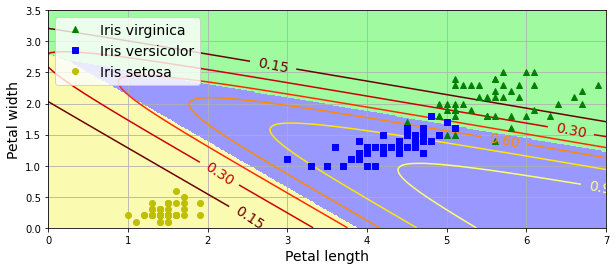

: 

In [ ]:
custom_cmap = mpl.colors.ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = (X_new - mean) / std
X_new_with_bias = np.c_[np.ones(len(X_new)), X_new]

logits = X_new_with_bias @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 7, 0, 3.5])
plt.grid()
plt.show()

And now let's measure the final model's accuracy on the test set:

In [ ]:
logits = X_test @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_test).mean()
accuracy_score

0.9666666666666667

: 

Well we get even better performance on the test set. This variability is likely due to the very small size of the dataset: depending on how you sample the training set, validation set and the test set, you can get quite different results. Try changing the random seed and running the code again a few times, you will see that the results will vary.

: 